In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import boxcox1p
import warnings; warnings.simplefilter('ignore')

In [2]:
train = pd.read_csv("train.csv", index_col='Id')
test = pd.read_csv("test.csv", index_col='Id')
data = train

**Fix typo**

In [3]:
train = train.replace('CmentBd', 'CemntBd')
test = test.replace('CmentBd', 'CemntBd')

train = train.replace('BrkCmn', 'BrkComm')
test = test.replace('BrkCmn', 'BrkComm')

train = train.replace('Brk Cmn', 'BrkComm')
test = test.replace('Brk Cmn', 'BrkComm')

train = train.replace('Wd Shng', 'WdShing')
test = test.replace('Wd Shng', 'WdShing')

**Analysis**

<AxesSubplot:>

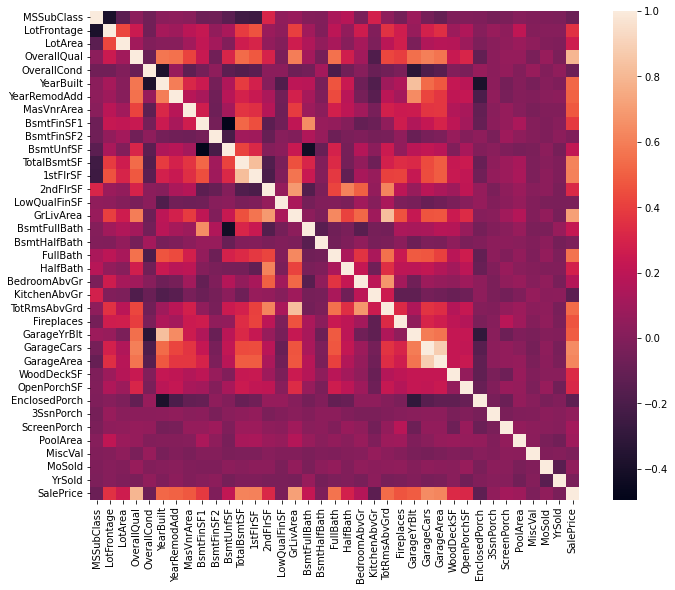

In [4]:
#heat map
corr_matrix = data.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corr_matrix, square=True)

In [5]:
#empty percentage
empty = data.isnull().sum().sort_values(ascending=False)/len(data)
empty[empty > 0]

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageYrBlt     0.055479
GarageCond      0.055479
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtCond        0.025342
BsmtQual        0.025342
BsmtFinType1    0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

**Data cleaning**

In [6]:
#outliners
train.drop(train[(train['TotalBsmtSF']>4000) & (train['SalePrice']<400000)].index, inplace=True)
train.drop(train[(train['1stFlrSF']>4000) & (train['SalePrice']<400000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<400000)].index, inplace=True)

In [7]:
Ytrain=train['SalePrice']
train=train[list(test)]
all_data=pd.concat((train, test), axis=0)
print(all_data.shape)
Ytrain=np.log(Ytrain+1)

(2917, 79)


In [8]:
#null values
cols=['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageCond','GarageType','GarageFinish','GarageQual','BsmtFinType2','BsmtExposure','BsmtQual','BsmtCond','BsmtFinType1','MasVnrType']
for col in cols:
    all_data[col] = all_data[col].fillna('None')
    
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x:x.fillna(x.median()))

#GarageYrBlt, GarageCars, GarageArea, MasVnrArea, since they are integer data type, we can fill in 0
#MasVnrType(NA)=>MasVnrArea(NA). Hence, if MasVnrType is None, MasVnrArea=0
all_data['GarageYrBlt']=all_data['GarageYrBlt'].fillna(0)
all_data['GarageCars']=all_data['GarageCars'].fillna(0)
all_data['GarageArea']=all_data['GarageArea'].fillna(0)
all_data['MasVnrArea']=all_data['MasVnrArea'].fillna(0)

#MSZoning, Using the mode group by Neighborhood to fill in the missing data
all_data['MSZoning'] = all_data.groupby('Neighborhood')['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

#Utilities(Both of the missing value is using Gas and no option is without electricity, so we use NoSeWa)
all_data['Utilities']=all_data['Utilities'].fillna('NoSeWa')

#BsmtFullBath, BsmtHalfBath,BsmtFinSF2, BsmtUnfSF, BsmtFinSF1, TotalBsmtSF,  since they are integer data type, we can fill in 0
all_data['BsmtFullBath']=all_data['BsmtFullBath'].fillna(0)
all_data['BsmtHalfBath']=all_data['BsmtHalfBath'].fillna(0)
all_data['BsmtFinSF2']=all_data['BsmtFinSF2'].fillna(0)
all_data['BsmtUnfSF']=all_data['BsmtUnfSF'].fillna(0)
all_data['BsmtFinSF1']=all_data['BsmtFinSF1'].fillna(0)
all_data['TotalBsmtSF']=all_data['TotalBsmtSF'].fillna(0)

#Functional, we can use the mode(Typ) to fill in the missing data
all_data['Functional']=all_data['Functional'].fillna(all_data['Functional'].mode()[0])

#KitchenQual, we can use TA, which is the mode in that column, to fill in the data
all_data['KitchenQual']=all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

#Exterior1st,Exterior2nd, using mode(VinylSd) to fill in the data
all_data['Exterior1st']=all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd']=all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

#SaleType, we use the mode(WD) to fill in the data
all_data['SaleType']=all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

#Electrical, we use the mode(SBrkr), which is also the basic one, to fill in the data
all_data['Electrical']=all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

print(f"Total count of missing values in all_data : {all_data.isnull().sum().sum()}")

Total count of missing values in all_data : 0


In [9]:
#quality mapping
all_data["LotShape"] = all_data["LotShape"].map({"IR3":1, "IR2":2, "IR1":3, "Reg":4})
all_data["LandContour"] = all_data["LandContour"].map({"Low":1, "HLS":2, "Bnk":3, "Lvl":4})
all_data["Utilities"] = all_data["Utilities"].map({"ELO":1, "NoSeWa":2, "NoSewr":3, "AllPub":4})
all_data["LandSlope"] = all_data["LandSlope"].map({"Sev":1, "Mod":2, "Gtl":3})
all_data["ExterQual"] = all_data["ExterQual"].map({"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
all_data["ExterCond"] = all_data["ExterCond"].map({"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
all_data["BsmtQual"] = all_data["BsmtQual"].map({"None":1, "Po":2, "Fa":3, "TA":4, "Gd":5, "Ex":6})
all_data["BsmtCond"] = all_data["BsmtCond"].map({"None":1, "Po":2, "Fa":3, "TA":4, "Gd":5, "Ex":6})
all_data["BsmtExposure"] = all_data["BsmtExposure"].map({"None":1, "No":2, "Mn":3, "Av":4, "Gd":5})
all_data["BsmtFinType1"] = all_data["BsmtFinType1"].map({"None":1, "Unf":2, "LwQ":3, "Rec":4, "BLQ":5, "ALQ":6, "GLQ":7})
all_data["BsmtFinType2"] = all_data["BsmtFinType2"].map({"None":1, "Unf":2, "LwQ":3, "Rec":4, "BLQ":5, "ALQ":6, "GLQ":7})
all_data["HeatingQC"] = all_data["HeatingQC"].map({"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
all_data["CentralAir"] = all_data["CentralAir"].map({"N":1, "Y":2})
all_data["KitchenQual"] = all_data["KitchenQual"].map({"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
all_data["Functional"] = all_data["Functional"].map({"Sal":1, "Sev":2, "Maj2":3, "Maj1":4, "Mod":5, "Min2":6, "Min1":7, "Typ":8})
all_data["FireplaceQu"] = all_data["FireplaceQu"].map({"None":1, "Po":2, "Fa":3, "TA":4, "Gd":5, "Ex":6})
all_data["GarageFinish"] = all_data["GarageFinish"].map({"None":1, "Unf":2, "RFn":3, "Fin":4})
all_data["GarageQual"] = all_data["GarageQual"].map({"None":1, "Po":2, "Fa":3, "TA":4, "Gd":5, "Ex":6})
all_data["GarageCond"] = all_data["GarageCond"].map({"None":1, "Po":2, "Fa":3, "TA":4, "Gd":5, "Ex":6})
all_data["PavedDrive"] = all_data["PavedDrive"].map({"N":1, "P":2, "Y":3})
all_data["Fence"] = all_data["Fence"].map({"None":1, "MnWw":2, "GdWo":3, "MnPrv":4, "GdPrv":5})

<AxesSubplot:>

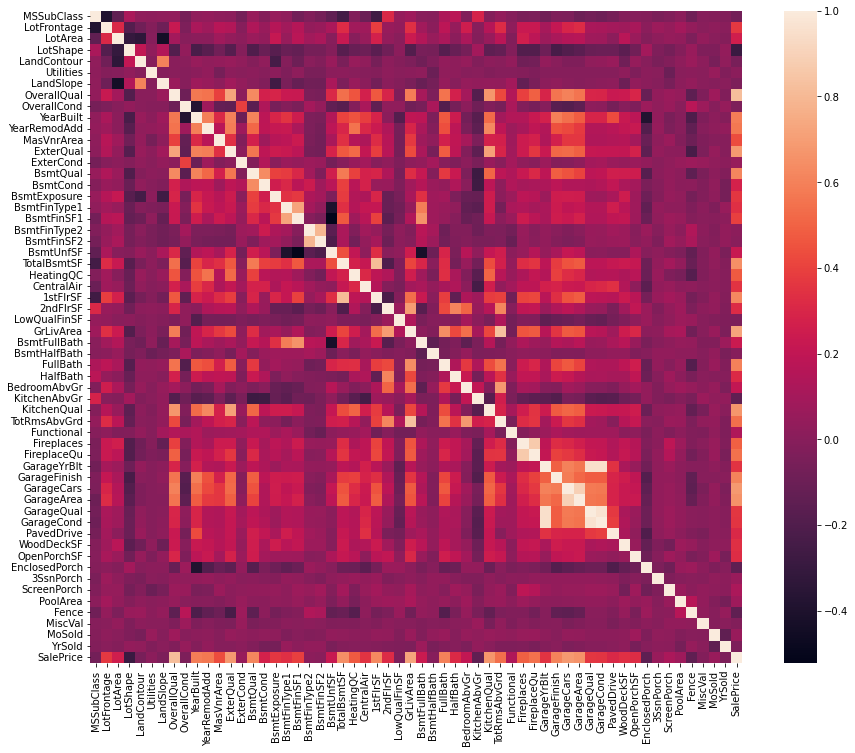

In [10]:
#heat map 2 / after mapping quality
combine = all_data[:len(train)]
combine['SalePrice'] = Ytrain
corr_matrix = combine.corr()
plt.subplots(figsize=(15, 12))
sns.heatmap(corr_matrix, square=True)

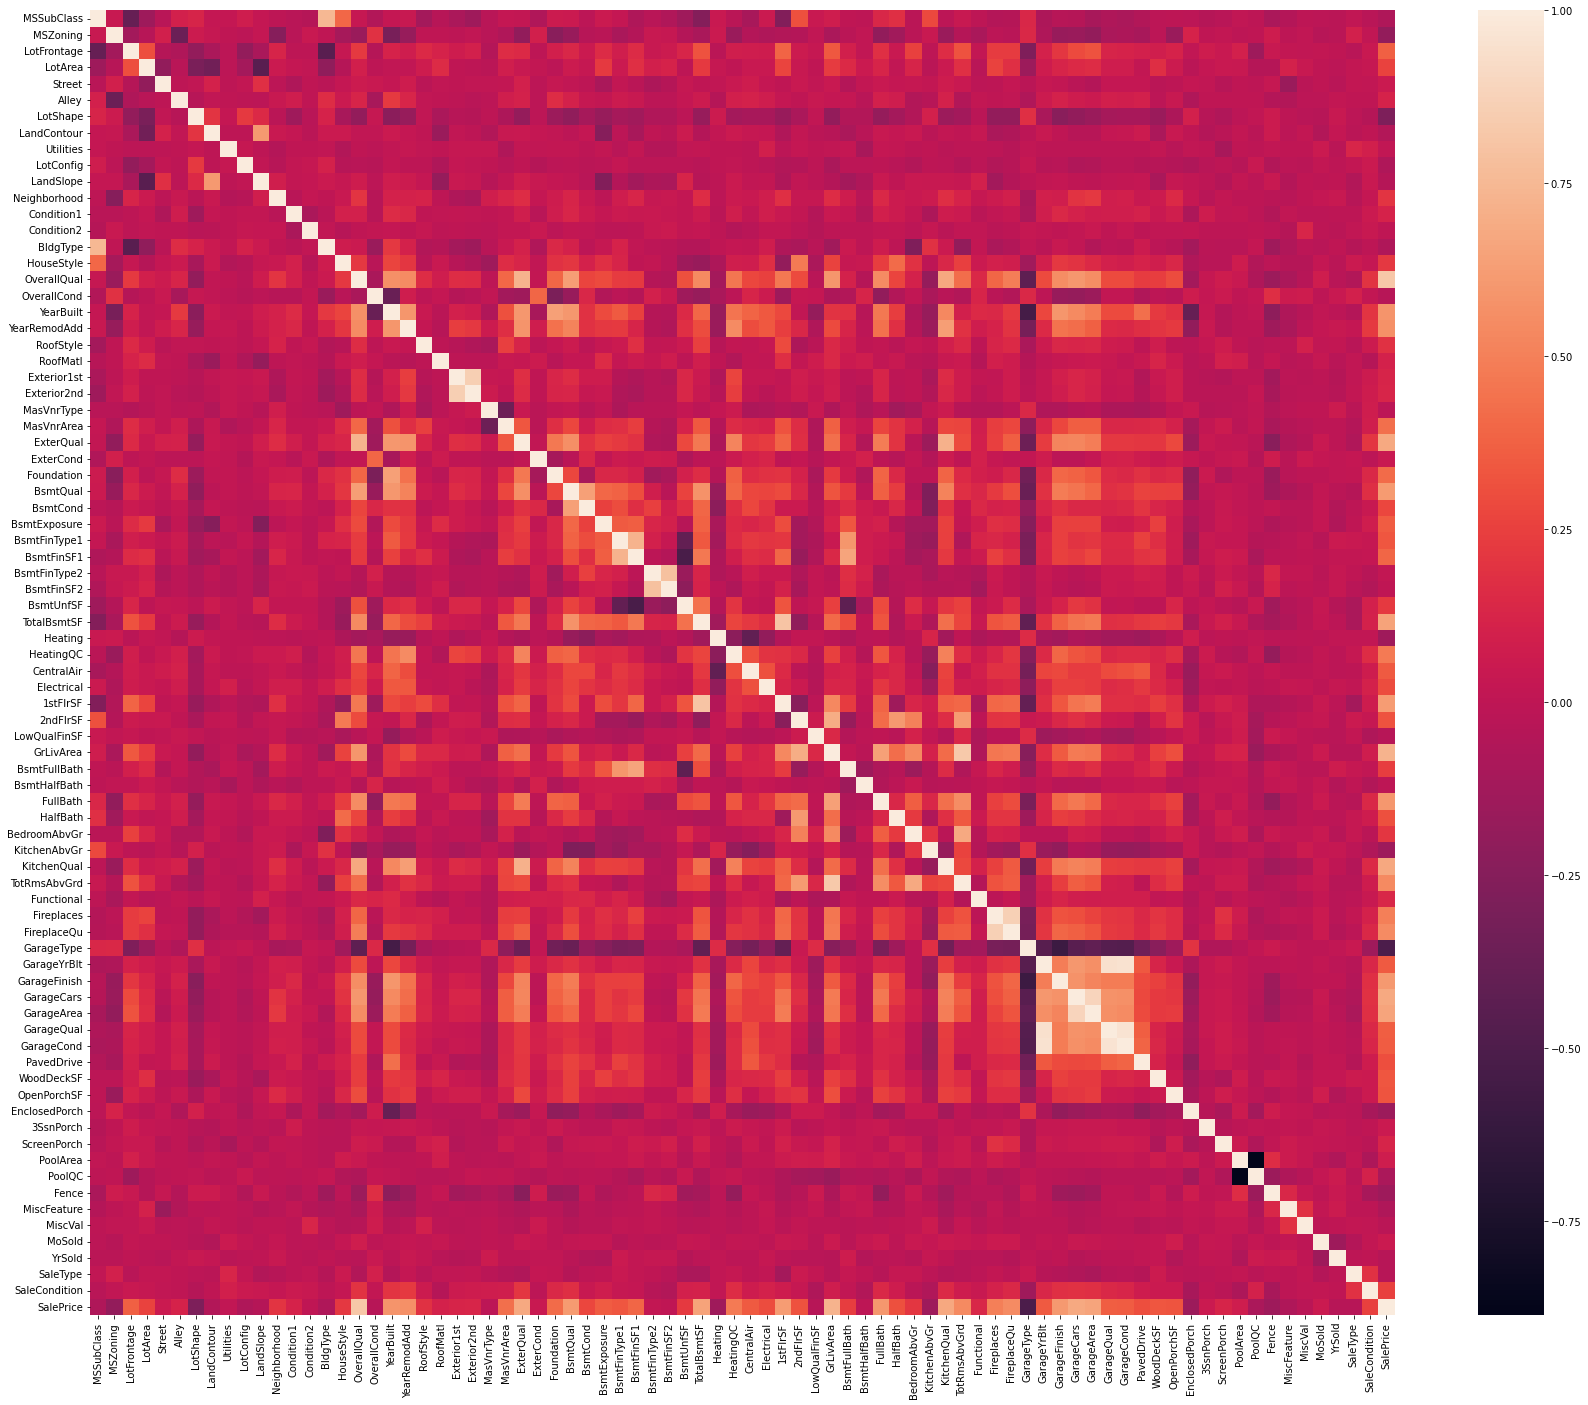

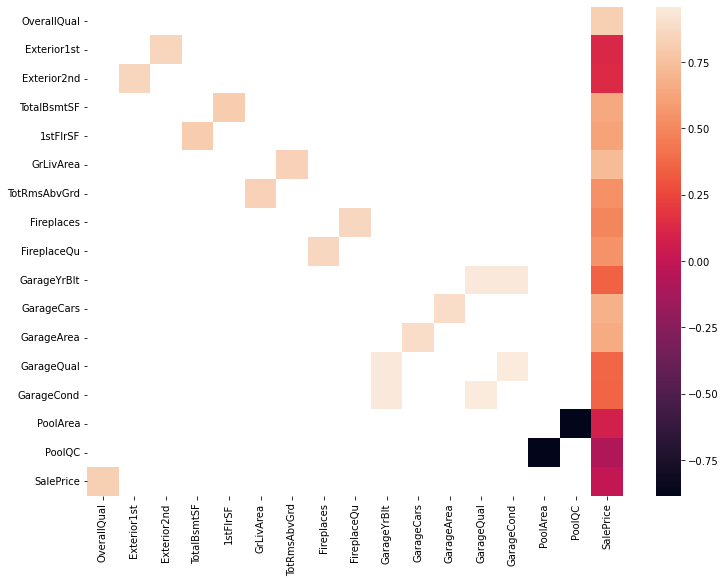

In [11]:
#heat map 2
combine = all_data[:len(train)]
combine['SalePrice'] = Ytrain

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

df = combine.select_dtypes(include=['object'])


for col in df:
    combine[col] = labelencoder.fit_transform(df[col])
    
#################################
corr_matrix = combine.corr()
plt.subplots(figsize=(30,24))
sns.heatmap(corr_matrix, square=True) 
#################################   

#>0.8 only
limit = 0.8
df_correlations = combine.corr()
for col in df_correlations:
    df_correlations[col][col] = 0

ndf = df_correlations.loc[abs(df_correlations).max(axis=1) >= limit, abs(df_correlations).max(axis=0) >= limit]
nndf = ndf[abs(ndf)>=limit]
nndf['SalePrice'] = ndf['SalePrice']
plt.subplots(figsize=(12, 9))
sns.heatmap(nndf)
plt.show()

In [12]:
#column merging
all_data['ExteriorMat'] = all_data['Exterior1st']
for i in all_data.index:
    if (all_data['Exterior1st'][i]==all_data['Exterior2nd'][i]):
        all_data['ExteriorMat'][i] = all_data['Exterior1st'][i]
    else:
        a = hash(all_data['Exterior1st'][i])
        b = hash(all_data['Exterior2nd'][i])
        if a>b:
            all_data['ExteriorMat'][i] = all_data['Exterior1st'][i] + "," + all_data['Exterior2nd'][i]
        else:
            all_data['ExteriorMat'][i] = all_data['Exterior2nd'][i] + "," + all_data['Exterior1st'][i]

In [13]:
#add features before dropping columns

all_data["Age"] = all_data["YrSold"] - all_data["YearBuilt"] + 1
all_data["AgeRemodel"] = all_data["YrSold"] - all_data["YearRemodAdd"] + 1
all_data["NoRemodel"] = all_data["YearBuilt"]==all_data["YearRemodAdd"]


all_data["TotalHouseSF"] = all_data["1stFlrSF"] + all_data["2ndFlrSF"] + all_data["TotalBsmtSF"]
all_data["TotalBath"] = all_data["BsmtFullBath"] + all_data["BsmtHalfBath"]/2 + all_data["FullBath"] + all_data["HalfBath"]/2
all_data["TotalPorchSF"] = all_data["WoodDeckSF"] + all_data["OpenPorchSF"] + all_data["EnclosedPorch"] + all_data["3SsnPorch"] + all_data["ScreenPorch"]


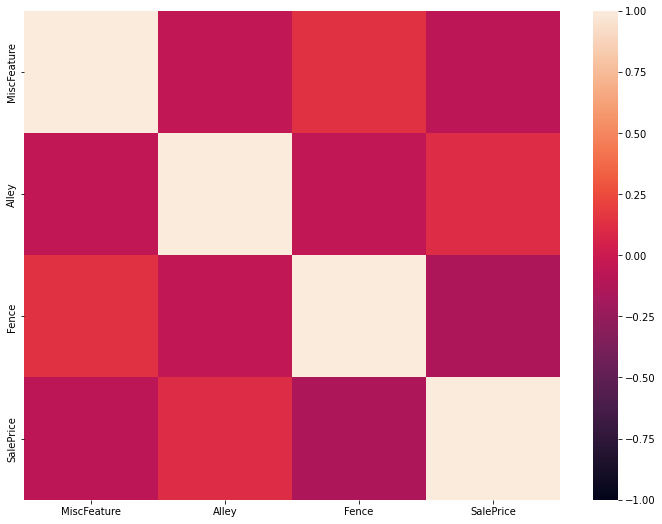

In [14]:
#heat map for checking high missing
combine = all_data[:len(train)]
combine = combine[['MiscFeature', 'Alley', 'Fence']]
combine['SalePrice'] = Ytrain

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

df = combine.select_dtypes(include=['object'])


for col in df:
    combine[col] = labelencoder.fit_transform(df[col])
    

corr_matrix = combine.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmin=-1, vmax=1)
plt.show()

In [15]:
#merged
all_data=all_data.drop(columns=['Exterior1st'])
all_data=all_data.drop(columns=['Exterior2nd'])

#remove multiple high corr
all_data=all_data.drop(columns=['GarageYrBlt'])

#less corr with sale prices compared to another similiar attribute (high corr)
all_data=all_data.drop(columns=['1stFlrSF'])
all_data=all_data.drop(columns=['TotRmsAbvGrd'])
all_data=all_data.drop(columns=['GarageArea'])
all_data=all_data.drop(columns=['GarageCond'])
all_data=all_data.drop(columns=['Fireplaces'])
all_data=all_data.drop(columns=['PoolQC'])

In [16]:
#>80% empty
all_data=all_data.drop(columns=['MiscFeature','Alley','Fence'])

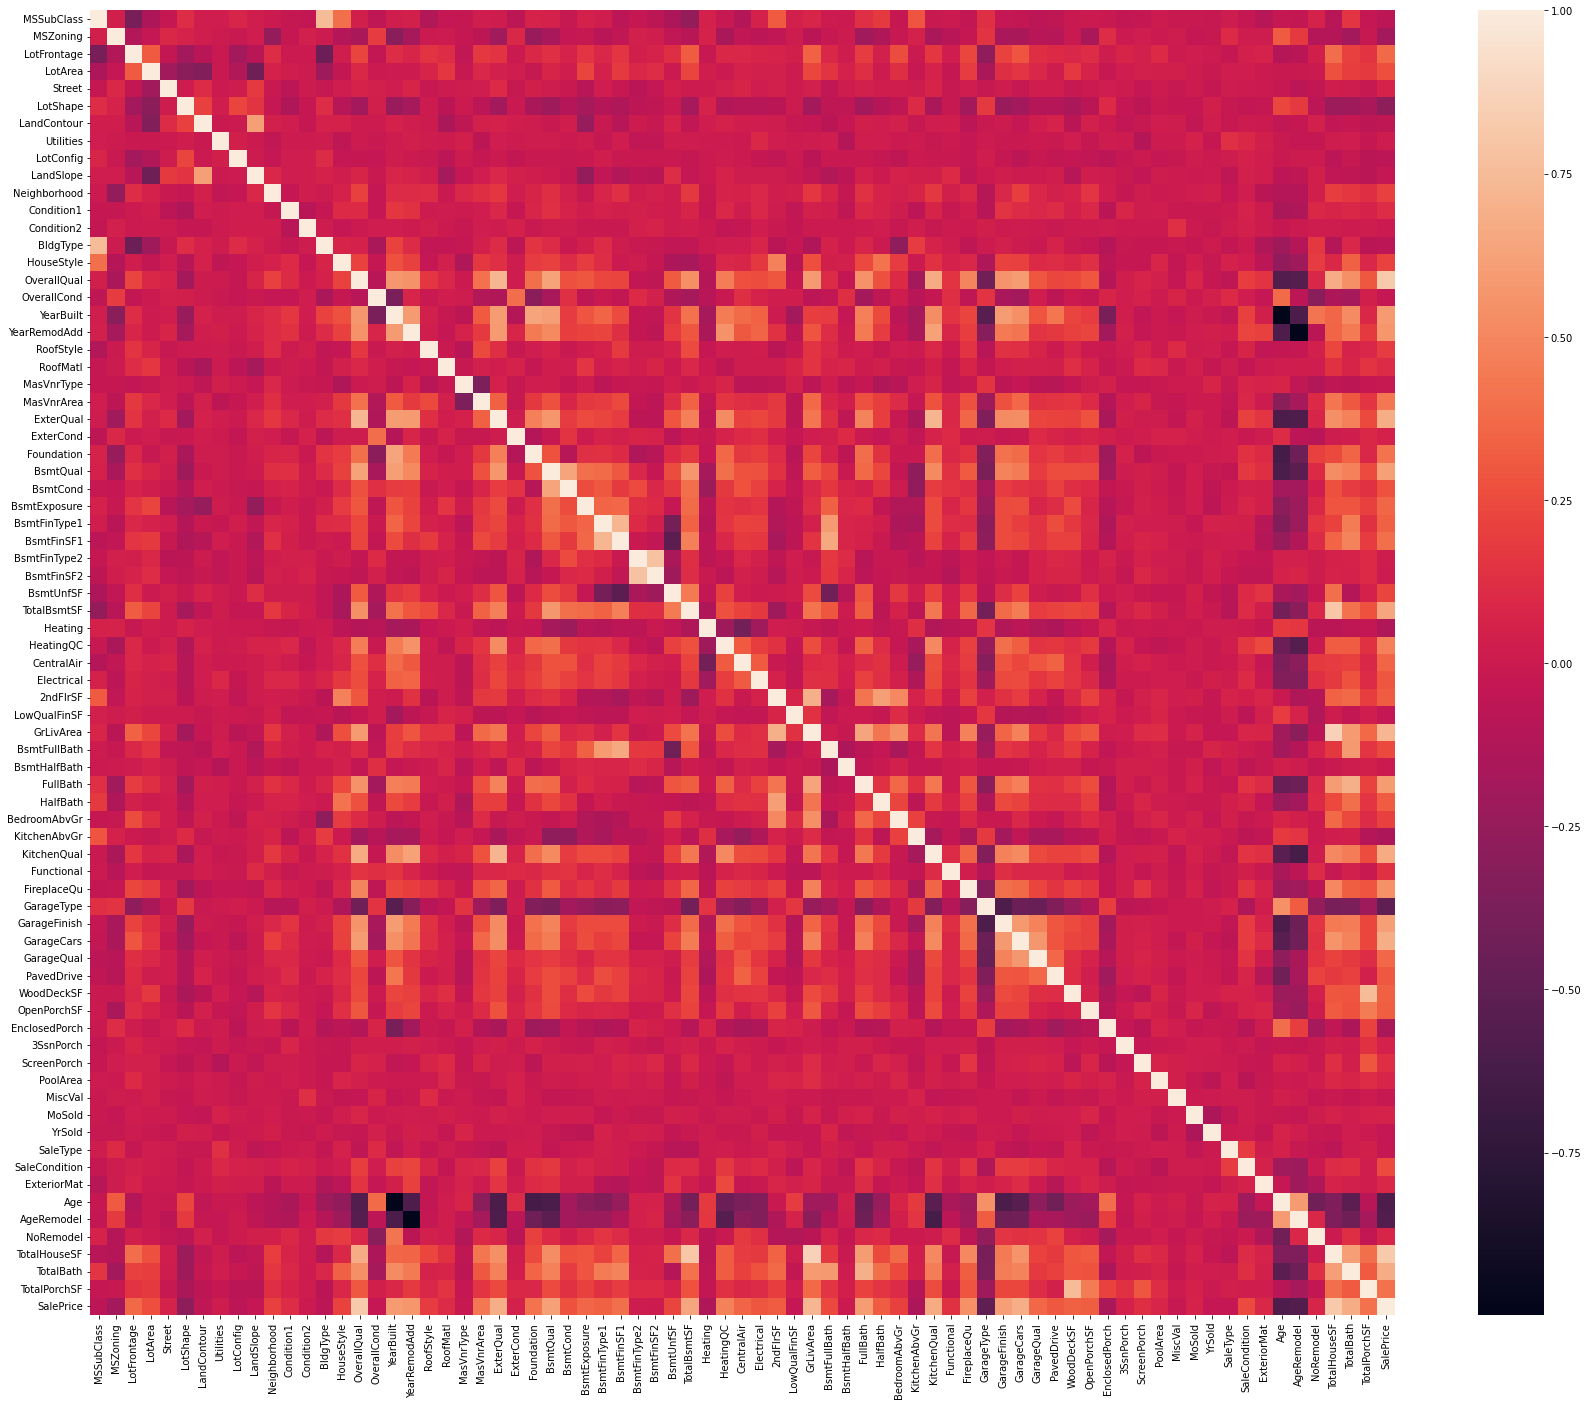

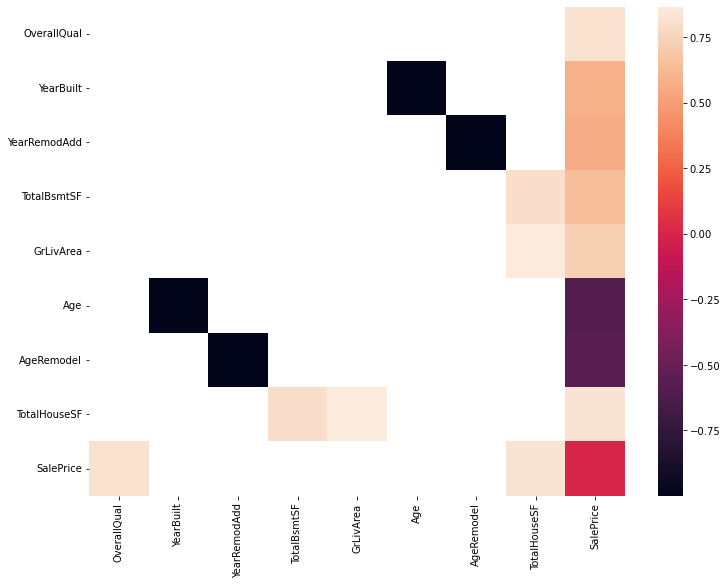

In [17]:
#heat map 3
combine = all_data[:len(train)]
combine['SalePrice'] = Ytrain

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

df = combine.select_dtypes(include=['object'])


for col in df:
    combine[col] = labelencoder.fit_transform(df[col])
    
#################################
corr_matrix = combine.corr()
plt.subplots(figsize=(30,24))
sns.heatmap(corr_matrix, square=True) 
#################################   

#>0.8 only
limit = 0.8
df_correlations = combine.corr()
for col in df_correlations:
    df_correlations[col][col] = 0

ndf = df_correlations.loc[abs(df_correlations).max(axis=1) >= limit, abs(df_correlations).max(axis=0) >= limit]
nndf = ndf[abs(ndf)>=limit]
nndf['SalePrice'] = ndf['SalePrice']
plt.subplots(figsize=(12, 9))
sns.heatmap(nndf)
plt.show()

In [18]:
# one hot coding
non_numeric=all_data.select_dtypes(np.object)

def onehot(col_list):
    global all_data
    while len(col_list) !=0:
        col=col_list.pop(0)
        data_encoded=pd.get_dummies(all_data[col], prefix=col)
        all_data=pd.merge(all_data, data_encoded, on='Id')
        all_data=all_data.drop(columns=col)
    print(all_data.shape)
    
onehot(list(non_numeric))

(2917, 247)


In [19]:
# log transformation - fix distribution
numeric=all_data.select_dtypes(np.number)

def log_transform(col_list):
    transformed_col=[]
    while len(col_list)!=0:
        col=col_list.pop(0)
        if all_data[col].skew() > 0.5:
            all_data[col]=np.log(all_data[col]+1)
            transformed_col.append(col)
        else:
            pass
    print(f"{len(transformed_col)} features had been tranformed")
    print(all_data.shape)

log_transform(list(numeric))

204 features had been tranformed
(2917, 247)


In [21]:
#split up data
print(train.shape, test.shape)
Xtrain=all_data[:len(train)]
Xtest=all_data[len(train):]
print(Xtrain.shape, Xtest.shape)

(1458, 79) (1459, 79)
(1458, 247) (1459, 247)


**Regression model**

In [22]:
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

In [23]:
# Regression models
# normalization with robust scaler

model_Knn = make_pipeline(RobustScaler(), KNeighborsRegressor())
model_Bayreg = make_pipeline(RobustScaler(), BayesianRidge(n_iter=20, tol=1e-30, alpha_1=1e-11, alpha_2 = 0.1, lambda_1=1, lambda_2=1e-30))
model_Linreg = make_pipeline(RobustScaler(), LinearRegression())
model_Randfor = make_pipeline(RobustScaler(), RandomForestRegressor())

In [24]:
# KNN regression
model_Knn.fit(Xtrain, Ytrain)
Knn_predictions = model_Knn.predict(Xtest)
train_Knn = model_Knn.predict(Xtrain)

In [25]:
# Bayesian regression
model_Bayreg.fit(Xtrain, Ytrain)
Bayreg_predictions = model_Bayreg.predict(Xtest)
train_Bayreg = model_Bayreg.predict(Xtrain)

In [26]:
# Linear regression
model_Linreg.fit(Xtrain, Ytrain)
Linreg_predictions = model_Linreg.predict(Xtest)
train_Linreg = model_Linreg.predict(Xtrain)

In [27]:
# Random forest regression
model_Randfor.fit(Xtrain, Ytrain)
Randfor_predictions = model_Randfor.predict(Xtest)
train_Randfor = model_Randfor.predict(Xtrain)

In [28]:
# Average rmse score of train data
log_train_predictions = (train_Knn + train_Bayreg + train_Linreg + train_Randfor) / 4
train_score=np.sqrt(mean_squared_error(Ytrain, log_train_predictions))
print(f"Scoring with train data : {train_score}")

Scoring with train data : 0.08227316411017771


In [29]:
# RMSE evaluation
def rmse(X):
    return np.sqrt(mean_squared_error(Ytrain, X))

print(
    rmse(train_Knn),
    rmse(train_Bayreg),
    rmse(train_Linreg),
    rmse(train_Randfor),
    rmse(log_train_predictions)
)

0.14254805590356498 0.0988475207910518 0.09352102144849796 0.05066662061669907 0.08227316411017771


In [30]:
# K-fold cross validation evaluation
def kFold(model):
    rmse = np.sqrt(-cross_val_score(model, Xtrain, Ytrain, scoring='neg_mean_squared_error', cv=5, n_jobs=-1))
    return rmse.mean()

print(
    kFold(model_Knn),
    kFold(model_Bayreg),
    kFold(model_Linreg),
    kFold(model_Randfor)
)

0.180971820931619 0.11271792773879655 3603199227.350717 0.1353579273427313


Bayesian ridge regression model is selected after k-fold and rmse evaluations.

In [31]:
# GridSearchCV for best parameters for Bayesian 
param_grid = [
    {'n_iter': [20], 'tol': [1e-30], 
     'alpha_1': [1e-11], 'alpha_2': [0.1],
     'lambda_1': [1], 'lambda_2': [1e-30]
    }
]
m = BayesianRidge()
grid_search = GridSearchCV(m, param_grid, cv=5, verbose=1, scoring='neg_root_mean_squared_error')
grid_search.fit(Xtrain, Ytrain);

# rmse
print("Training:",-grid_search.score(Xtrain, Ytrain), " vs testing: ",-grid_search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training: 0.09722515155874105  vs testing:  0.11289066185846226


In [32]:
# predictions=Bayreg_predictions
predictions=np.exp(Bayreg_predictions)-1

In [34]:
predictions.shape

(1459,)

In [33]:
from datetime import datetime
now = datetime.now()

submission=pd.read_csv('sample_submission.csv', index_col='Id')
submission['SalePrice']=predictions
submission.to_csv("submission_" + now.strftime("%d-%m-%Y-%H%M") + ".csv")
display(submission.head())

,SalePrice
Id,
1461,114846.874932
1462,162404.841474
1463,181143.040686
1464,194196.314973
1465,198659.202214
